In [2]:
import pandas as pd
import numpy as np

In [3]:
df_soap = pd.read_pickle("./df_soapmod.pkl")

In [4]:
df_soap = df_soap[df_soap["defect_formation_energy"] > 0]

df_soap_dropped = df_soap.drop(["name","formula","mp_id", "host_structure", "defect_index", "defect_structure_relaxed", "defect_structure_original","defect_formation_energy"],axis=1)

y = df_soap["defect_formation_energy"]

In [5]:
df_soap.shape

(1665, 656)

In [6]:
def corr_reduction(corr, thresh, data):    
    columns = np.full((corr.shape[0],), True, dtype=bool)
    for i in range(corr.shape[0]):
        for j in range(i+1, corr.shape[0]):
            if corr.iloc[i,j] >= thresh:
                if columns[j]:
                    columns[j] = False
    print(columns)
    selected_columns = data.columns[columns]
    data = data[selected_columns]
    return data

In [7]:
df_soap_reduced = corr_reduction(df_soap_dropped.corr(), 0.9, df_soap_dropped)


[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True False  True False False False False False False
 False False False False False False  True  True  True  True False False
  True  True  True  True  True False  True  True False  True  True  True
  True  True  True False  True  True  True  True  True  True False False
  True  True False  True False  True False  True False False False  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True False  True  True  True False  True  True
  True  True  True  True  True  True  True False  True  True  True  True
  True  True  True  True  True  True  True False  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True False  True  True  T

In [8]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestRegressor
kf = KFold(n_splits = 5, shuffle = True, random_state = 42)

rf_soap_cv = RandomForestRegressor()
output_soap = cross_validate(rf_soap_cv, df_soap_reduced, y, cv = kf, scoring = 'neg_root_mean_squared_error', return_estimator = True)




In [9]:
output_soap["test_score"].mean()

-0.8379588871792096

In [10]:
df_soap_reduced.shape

(1665, 423)

In [11]:
def extract_importances(output):
    overall_cm = {}
    for idx,estimator in enumerate(output['estimator']):
        feature_importances = pd.DataFrame(estimator.feature_importances_,
                                           index = estimator.feature_names_in_,
                                            columns=['importance']).sort_values('importance', ascending=False)
        feature_importances = feature_importances.rename(columns = {"importance":"importance" + str(idx)})
        overall_cm[idx] = feature_importances


    overall_cm_df = overall_cm[0]
    overall_cm_df = overall_cm_df.merge(overall_cm[1], left_index = True, how = 'outer', right_index =True)
    overall_cm_df = overall_cm_df.merge(overall_cm[2], left_index = True, how = 'outer', right_index =True)
    overall_cm_df = overall_cm_df.merge(overall_cm[3], left_index = True, how = 'outer', right_index =True)
    overall_cm_df = overall_cm_df.merge(overall_cm[4], left_index = True, how = 'outer', right_index =True)
    overall_cm_df["average"] = overall_cm_df.mean(axis = 1)
    return overall_cm_df
def iterative_remove(df_imp, df_data):
    df_reduced = df_data
    df_imp = df_imp.sort_values("average")
    idx = round(len(df_imp)*0.10)
    df_imp = df_imp[idx:]
    to_keep = df_imp.index.values.tolist()
    df_reduced = df_data[to_keep]
    return df_reduced

In [12]:
overall_soap_df = extract_importances(output_soap)

In [13]:
overall_soap_df.head()

,importance0,importance1,importance2,importance3,importance4,average
mean SOAP_0,0.001037,0.001282,0.002351,0.001102,0.001132,0.001381
mean SOAP_1,0.001437,0.000519,0.001753,0.001993,0.002314,0.001603
mean SOAP_100,0.001482,0.000864,0.001148,0.000861,0.001897,0.001250
mean SOAP_101,0.002310,0.002173,0.003061,0.003523,0.003653,0.002944
mean SOAP_102,0.005912,0.004371,0.005612,0.003339,0.003315,0.004510


In [14]:
df_soap_reduced1 = iterative_remove(overall_soap_df,df_soap_reduced)
output_soap1 = cross_validate(rf_soap_cv, df_soap_reduced1, y, cv = kf, scoring = 'neg_root_mean_squared_error', return_estimator = True)

overall_soap_df1 = extract_importances(output_soap1)


In [15]:
df_soap_reduced2 = iterative_remove(overall_soap_df1,df_soap_reduced)
output_soap2 = cross_validate(rf_soap_cv, df_soap_reduced2, y, cv = kf, scoring = 'neg_root_mean_squared_error', return_estimator = True)

overall_soap_df2 = extract_importances(output_soap2)


In [16]:
df_soap_reduced3 = iterative_remove(overall_soap_df2,df_soap_reduced)
output_soap3 = cross_validate(rf_soap_cv, df_soap_reduced3, y, cv = kf, scoring = 'neg_root_mean_squared_error', return_estimator = True)

overall_soap_df3 = extract_importances(output_soap3)


In [17]:
df_soap_reduced4 = iterative_remove(overall_soap_df3,df_soap_reduced)
output_soap4 = cross_validate(rf_soap_cv, df_soap_reduced4, y, cv = kf, scoring = 'neg_root_mean_squared_error', return_estimator = True)

overall_soap_df4 = extract_importances(output_soap4)


In [18]:
output_soap4["test_score"].mean()

-0.834250826472568

In [19]:
df_soap_reduced5 = iterative_remove(overall_soap_df4,df_soap_reduced)
output_soap5 = cross_validate(rf_soap_cv, df_soap_reduced5, y, cv = kf, scoring = 'neg_root_mean_squared_error', return_estimator = True)

overall_soap_df5 = extract_importances(output_soap5)


In [20]:
df_soap_reduced6 = iterative_remove(overall_soap_df5,df_soap_reduced)
output_soap6 = cross_validate(rf_soap_cv, df_soap_reduced6, y, cv = kf, scoring = 'neg_root_mean_squared_error', return_estimator = True)

overall_soap_df6 = extract_importances(output_soap6)


In [21]:
df_soap_reduced7 = iterative_remove(overall_soap_df6,df_soap_reduced)
output_soap7 = cross_validate(rf_soap_cv, df_soap_reduced7, y, cv = kf, scoring = 'neg_root_mean_squared_error', return_estimator = True)

overall_soap_df7 = extract_importances(output_soap7)


In [22]:
df_soap_reduced8 = iterative_remove(overall_soap_df7,df_soap_reduced)
output_soap8 = cross_validate(rf_soap_cv, df_soap_reduced8, y, cv = kf, scoring = 'neg_root_mean_squared_error', return_estimator = True)

overall_soap_df8 = extract_importances(output_soap8)


In [23]:
df_soap_reduced9 = iterative_remove(overall_soap_df8,df_soap_reduced)
output_soap9 = cross_validate(rf_soap_cv, df_soap_reduced9, y, cv = kf, scoring = 'neg_root_mean_squared_error', return_estimator = True)

overall_soap_df9 = extract_importances(output_soap9)


In [24]:
df_soap_reduced10 = iterative_remove(overall_soap_df9,df_soap_reduced)
output_soap10 = cross_validate(rf_soap_cv, df_soap_reduced10, y, cv = kf, scoring = 'neg_root_mean_squared_error', return_estimator = True)

overall_soap_df10 = extract_importances(output_soap10)


In [25]:
df_soap_reduced11 = iterative_remove(overall_soap_df10,df_soap_reduced)
output_soap11 = cross_validate(rf_soap_cv, df_soap_reduced11, y, cv = kf, scoring = 'neg_root_mean_squared_error', return_estimator = True)

overall_soap_df11 = extract_importances(output_soap11)


In [26]:
df_soap_reduced12 = iterative_remove(overall_soap_df11,df_soap_reduced)
output_soap12 = cross_validate(rf_soap_cv, df_soap_reduced12, y, cv = kf, scoring = 'neg_root_mean_squared_error', return_estimator = True)

overall_soap_df12 = extract_importances(output_soap12)


In [27]:
df_soap_reduced13 = iterative_remove(overall_soap_df12,df_soap_reduced)
output_soap13 = cross_validate(rf_soap_cv, df_soap_reduced13, y, cv = kf, scoring = 'neg_root_mean_squared_error', return_estimator = True)

overall_soap_df13 = extract_importances(output_soap13)


In [28]:
df_soap_reduced14 = iterative_remove(overall_soap_df13,df_soap_reduced)
output_soap14 = cross_validate(rf_soap_cv, df_soap_reduced14, y, cv = kf, scoring = 'neg_root_mean_squared_error', return_estimator = True)

overall_soap_df14 = extract_importances(output_soap14)


In [29]:
df_soap_reduced15 = iterative_remove(overall_soap_df14,df_soap_reduced)
output_soap15 = cross_validate(rf_soap_cv, df_soap_reduced15, y, cv = kf, scoring = 'neg_root_mean_squared_error', return_estimator = True)

overall_soap_df15 = extract_importances(output_soap15)


In [30]:
output_list = [output_soap,output_soap1,output_soap2,output_soap3,output_soap4,output_soap5,output_soap6,output_soap7,output_soap8,output_soap9,output_soap10,output_soap11,output_soap12,output_soap13,output_soap14,output_soap15]
output_list_df = [df_soap_reduced,df_soap_reduced1,df_soap_reduced2,df_soap_reduced3,df_soap_reduced4,df_soap_reduced5,df_soap_reduced6,df_soap_reduced7,df_soap_reduced8,df_soap_reduced9,df_soap_reduced10,df_soap_reduced11,df_soap_reduced12,df_soap_reduced13,df_soap_reduced14,df_soap_reduced15]


<AxesSubplot:xlabel='Length', ylabel='Average RMSE Score (5CV)'>

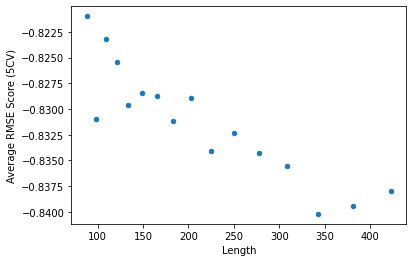

In [31]:
soap_lens = [x.shape[1] for x in output_list_df]
soap_scores = [x['test_score'].mean() for x in output_list]
df_soap_reduction = pd.DataFrame({"Length":soap_lens, "Average RMSE Score (5CV)":soap_scores})
df_soap_reduction.plot.scatter(x = "Length", y = "Average RMSE Score (5CV)")

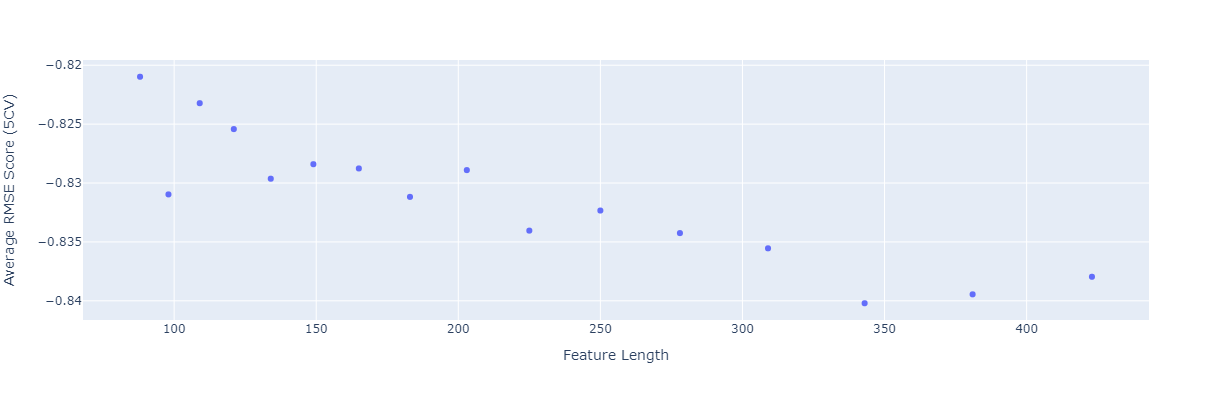

In [34]:
import plotly.express as px

px.scatter(df_soap_reduction, x = "Length", y = "Average RMSE Score (5CV)", width= 700, height = 400, labels = {"Length":"Feature Length"})

In [33]:
rf_

NameError: name 'rf_' is not defined